<a href="https://colab.research.google.com/github/abhisekdey12/python_codes/blob/master/assignment_bus_stops_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook contains the end to end solution for assignment-bus-stops

In [31]:
# Importing Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [5]:
# Importing dataset
df = pd.read_csv('/content/ds-assignment-bus-stops-data.csv')

## **Exploration Data Analysis**

In [52]:
# Location spread overview
basemap = "carto-positron" # B/W map

fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    zoom=5,
    height=600
)

fig.update_layout(
    mapbox_style=basemap,
    mapbox_zoom=12,
    title="Visualizing all Geo-points"
)

fig.show()

In [41]:
fig = px.density_mapbox(
    df,
    lat="lat",
    lon="lon",
    radius=2,
    zoom=5,
    height=600
)

fig.update_layout(
    mapbox_style=basemap,
    mapbox_zoom=12,
    title="Heatmap of Geo-Points"
)

fig.show()

Takeaways:
1.   A clear circular main route is observed
2.   A few diversions towards left (west) and bottom (south) observed



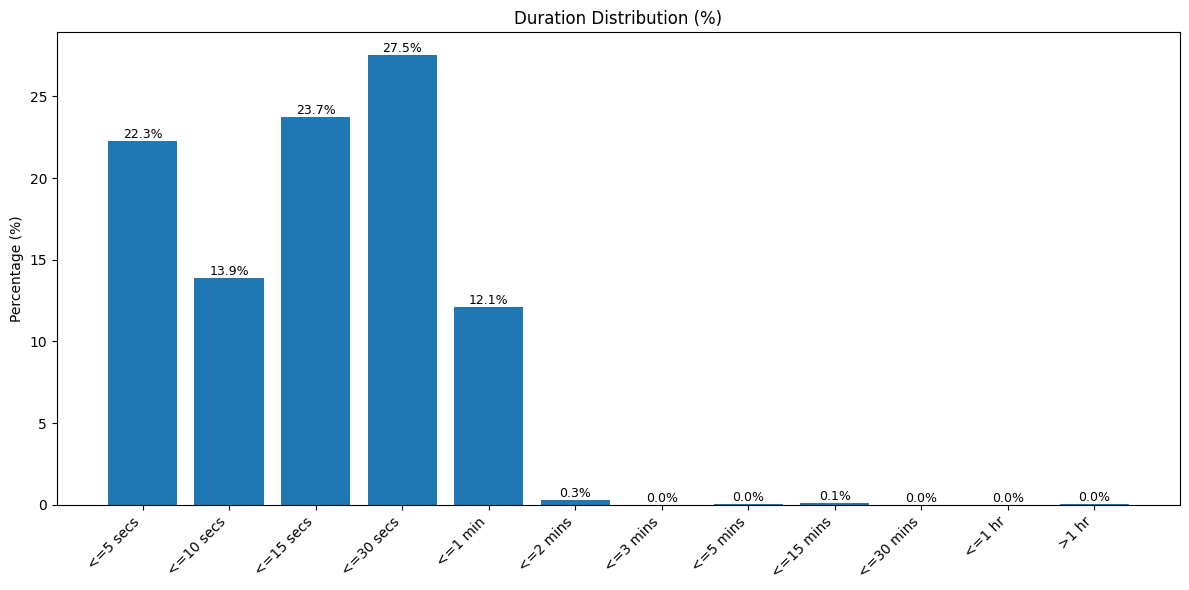

In [12]:
# Breaking down duration variable

# Duration bins
bins = [0, 5, 10, 15, 30, 60, 120, 180, 300, 900, 1800, 3600, np.inf]

# Duration labels
labels = [
    '<=5 secs',
    '<=10 secs',
    '<=15 secs',
    '<=30 secs',
    '<=1 min',
    '<=2 mins',
    '<=3 mins',
    '<=5 mins',
    '<=15 mins',
    '<=30 mins',
    '<=1 hr',
    '>1 hr'
]

# Binning
df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=labels, right=True, include_lowest=True)

# % count in each bucket
pct = df['duration_bin'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(12,6))
bars = plt.bar(pct.index, pct.values)

# Add percentage labels above bars
for bar, value in zip(bars, pct.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{value:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage (%)")
plt.title("Duration Distribution (%)")
plt.tight_layout()
plt.show()

Takesaways:
*   The stop duration is usually < 60 secs in 99.5% cases




In [13]:
# looking at the bus stops wrt duration

bins = [0, 60, 300, 3600, np.inf]

# Define labels
labels = [
    '<= 1 min',
    '1 to 5 mins',
    '5 mins to 1 hr',
    '>1 hr'
]

# Bin the duration column
df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=labels, right=True, include_lowest=True)

basemap = "carto-positron"

fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="duration_bin",
    hover_data=["duration"],
    zoom=5,
    height=600
)

# Apply basemap
fig.update_layout(
    mapbox_style=basemap,
    mapbox_zoom=13
)

fig.show()

Takeaways:
* Stops >1 hr (in purple) potentially suggests depot locations
* points with stop duration of >1 min and <= 5 mins (Orange) may indicate long stops, maybe to accomodation assisted boarding/deboarding/rush hour queues/traffic congestion at bus-stops
* Stops with > 5mins and <=1 hr (Aqua blue) may indicate may indicate breakdown or unplanned charging stops





In [16]:
# Breaking down start column
df['start_dt'] = pd.to_datetime(df['start'], unit='ms', utc=True)
df['hour'] = df['start_dt'].dt.hour

bins = [0, 6, 12, 18, 22, 24]
labels = ['0–6 hrs', '6–12 hrs', '12–18 hrs', '18–22 hrs', '22-24 hrs']

df['time_of_day_bin'] = pd.cut(df['hour'], bins=bins, labels=labels, right=False, include_lowest=True)

# plot
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="time_of_day_bin",
    hover_data=["hour"],
    zoom=5,
    height=600
)

fig.update_layout(
    mapbox_style=basemap,
    mapbox_zoom=12
)

fig.show()

Takeaways:
*   The route deviation observed on the left is only active during after midday. There isn't enough data prove this hytpthesis
*   The main route is operational 24/7



## **Unsupervised Learning Approach to Determine Bustop and their coordinates**

Using Density based clustering approach
This approach is chosen since the dataset is contains geospatial data and DBSCAN can use haversine to accuracte compute the clusters

In [42]:
# Step 1
'''
Data Pre-processing - Removing data where stop duration is higher than 1 min. This step removes 0.5% of the data
'''
df_filtered = df.loc[df['duration']<= 60].copy() # Filtering records where stop duration <= 1 min
coords = df_filtered[['lat', 'lon']].values # Extarcting coordinates
coords_rad = np.radians(coords) # Converting to radians for haversine calculations

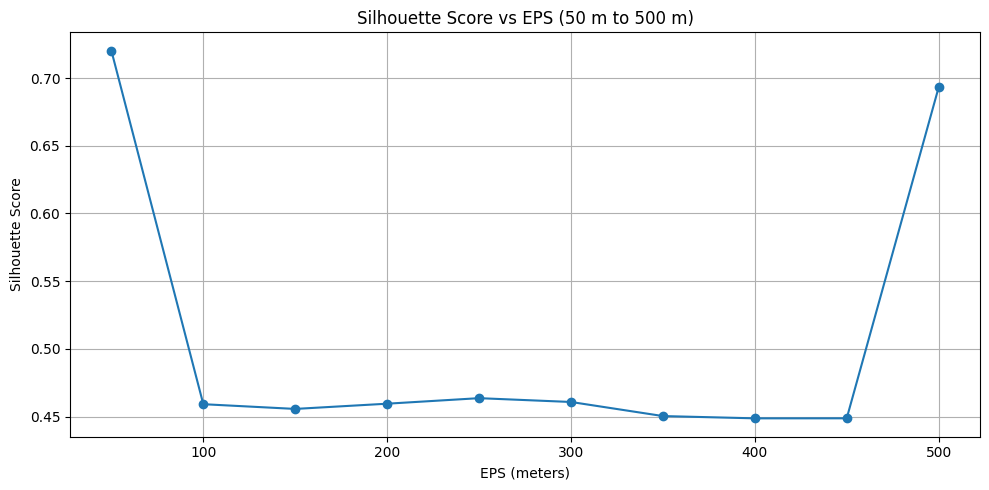

In [22]:
# Step 2
'''
EPS - Determines the max distance considered for cluster points
Determining the best fit EPS value keeping the min-value constant at 30 which is 0.1% of the data
'''

EARTH_RADIUS = 6371000

eps_values_m = np.arange(50, 501, 50) # EPS values ranging from 50 to 500 meters, incrementing by 50 m
sil_scores = []

for eps_m in eps_values_m:
    eps_rad = eps_m / EARTH_RADIUS  # to radians

    db = DBSCAN(
        eps=eps_rad,
        min_samples=30,
        metric='haversine' # measure distance on earth surface
    ).fit(coords_rad)

    labels = db.labels_

    # Filter out noise
    mask = labels != -1
    coords_filtered = coords[mask]
    labels_filtered = labels[mask]

    score = silhouette_score(coords_rad, labels, metric='haversine')

    sil_scores.append(score)

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(eps_values_m, sil_scores, marker='o')
plt.xlabel("EPS (meters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs EPS (50 m to 500 m)")
plt.grid(True)
plt.tight_layout()
plt.show()

Takeaways:
1.   Silhouette score > 0.5 is considered a good score, depicting good cluster value seperation
2.   Based on the graph, at EPS = 500m the graph peaks above the 0.5 score. Therefore this score can be considered as max distance of cluster points
1.   50m is not chosen because the cluster points although properly seperated, may suggest bustops within few hundred (e.g - 200,300) meters of radius





In [54]:
# Creating Cluster
'''
Creating the clusters based on the determined EPS
'''
eps_500m = 500/EARTH_RADIUS  # based on step 2

db = DBSCAN(
    eps=eps_500m,
    min_samples=30,
    metric='haversine').fit(coords)

df_filtered['cluster'] = db.labels_.astype(str)   # convert to string for discrete colors

# Replace -1 with label "noise"
df_filtered['cluster'] = df_filtered['cluster'].replace({'-1': 'noise'})

fig = px.scatter_mapbox(
    df_filtered.loc[df_filtered['cluster'] != 'noise'], # filtering noise in the plot
    lat="lat",
    lon="lon",
    color="cluster",
    zoom=14,
    height=700,
    hover_data={"cluster": True, "lat": False, "lon": False}
)

fig.update_layout(mapbox_style=basemap, # B/W style
                  title="Bus Stop Clusters")

fig.show()

Takeaways:
1.   Showcases the final clusters i.e. bus-stops based on the given route information  
2.   All bustops seems to be well separated, some are in close proximity but not too close.



In [24]:
'''
Final Silhoutte Score
'''

labels = db.labels_

# Filtering noise - it may affect the scores
mask = labels != -1
coords_filtered = coords[mask]
labels_filtered = labels[mask]

score = silhouette_score(coords_rad, labels, metric='haversine')

print('Final Score : ',score.round(5))

Final Score :  0.75506


In [45]:
# Calculating cluster centroids
centroids = (
    df_filtered[df_filtered['cluster'] != 'noise']  # exclude noise
    .groupby('cluster')[['lat', 'lon']]             # Cluster-wise groups
    .mean()                                         # centroid = mean position
    .reset_index()
)

centroids['cluster'] = centroids['cluster'].astype(int)
centroids.sort_values(by='cluster')

cluster        lat       lon
0         0  52.207745  5.791546
1         1  52.212490  5.793627
12        2  52.215148  5.790403
19        3  52.215484  5.788885
20        4  52.215966  5.785803
21        5  52.216503  5.782286
22        6  52.215813  5.772796
23        7  52.207211  5.773335
24        8  52.204675  5.775983
25        9  52.216156  5.777314
2        10  52.207440  5.771331
3        11  52.206499  5.775242
4        12  52.202272  5.780888
5        13  52.211368  5.790903
6        14  52.212976  5.793202
7        15  52.215860  5.787257
8        16  52.202081  5.779677
9        17  52.203508  5.778012
10       18  52.213217  5.771716
11       19  52.211927  5.770415
13       20  52.207608  5.772234
14       21  52.202777  5.778860
15       22  52.205650  5.774747
16       23  52.203990  5.776140
17       24  52.216571  5.781365
18       25  52.208260  5.790709

In [55]:
# Representing cluster centriods on the map
fig = px.scatter_mapbox(
    centroids,
    lat="lat",
    lon="lon",
    color="cluster",
    zoom=14,
    height=700,
    hover_data={"cluster": True, "lat": False, "lon": False}
)

# Black & white map style
fig.update_layout(mapbox_style=basemap, # B/W style
                  title="Cluster Centrids")

fig.show()

## **Conclusion**
Based on the above analysis:
1.   The main route has 26 bus-stops separated by atleast 500m, where is bus halts for almost 1 min
2.   The bus service operates 24/7
1.   A depot location is inferred based on high stop duration >1 hr
2.   There are some observed deviations/detours, one which operates after midday. But there isn't enough data to verify the hypothesis



